# Import Libraries

In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


In [2]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

# Prepare CASIA Dataset

## Download Dataset from Kaggle

### Mount GDrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Kaggle Connection

In [2]:
! pip install -q kaggle

from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sophatvathana/casia-dataset

100% 5.20G/5.22G [01:20<00:00, 52.3MB/s]
100% 5.22G/5.22G [01:20<00:00, 69.6MB/s]


### Extract to GDrive

In [ ]:
! mkdir 'drive/MyDrive/ela-train'
! unzip casia-dataset.zip -d 'drive/MyDrive/ela-train'

# Utility Functions

In [4]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

# Exploration

Pristine Image

In [5]:
drive_path = 'drive/MyDrive/ela-train/'

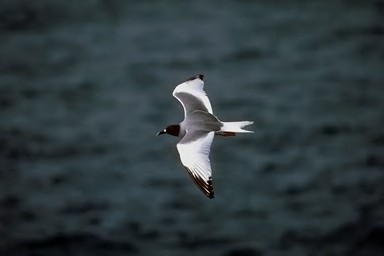

In [6]:
pristine_image_path = drive_path + 'casia/CASIA2/Au/Au_ani_00010.jpg'
Image.open(pristine_image_path)

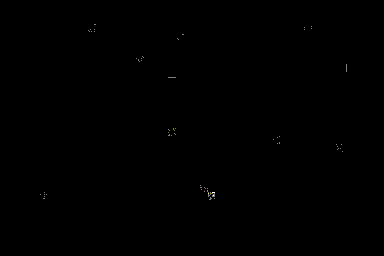

In [7]:
convert_to_ela_image(pristine_image_path, 90)

Fake Image

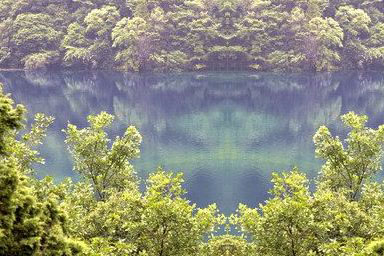

In [8]:
fake_image_path = drive_path + 'casia/CASIA2/Tp/Tp_D_CNN_M_N_nat00089_nat00089_10576.jpg'
Image.open(fake_image_path)

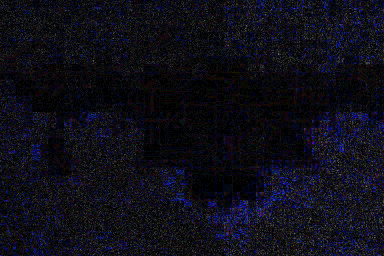

In [9]:
convert_to_ela_image(fake_image_path, 90)

# Dataset Preparation

In [10]:
image_size = (128, 128)

In [11]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [12]:
X = []
Y = []

Au => Total Images 7354, Take 2100 random images from the list
Tp => Total Images 2064

In [13]:
import random
path = drive_path + 'CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(X) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [ ]:
path = drive_path + 'CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [ ]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)

3331 3331
833 833


# CNN Model

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               29491456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [ ]:
epochs = 30
batch_size = 32


In [ ]:
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

In [ ]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30
105/105 [==============================] - 2s 23ms/step - loss: 0.4886 - accuracy: 0.7820 - val_loss: 0.3646 - val_accuracy: 0.8715
Epoch 2/30
105/105 [==============================] - 2s 21ms/step - loss: 0.3165 - accuracy: 0.8865 - val_loss: 0.2964 - val_accuracy: 0.9040
Epoch 3/30
105/105 [==============================] - 2s 20ms/step - loss: 0.2671 - accuracy: 0.9054 - val_loss: 0.2737 - val_accuracy: 0.9052
Epoch 4/30
105/105 [==============================] - 2s 20ms/step - loss: 0.2281 - accuracy: 0.9201 - val_loss: 0.2070 - val_accuracy: 0.9232
Epoch 5/30
105/105 [==============================] - 2s 21ms/step - loss: 0.2094 - accuracy: 0.9207 - val_loss: 0.1856 - val_accuracy: 0.9304
Epoch 6/30
105/105 [==============================] - 2s 20ms/step - loss: 0.1700 - accuracy: 0.9361 - val_loss: 0.1651 - val_accuracy: 0.9316
Epoch 7/30
105/105 [==============================] - 2s 21ms/step - loss: 0.1462 - accuracy: 0.9427 - val_loss: 0.1574 - val_accuracy: 0.9376

In [ ]:
model.save(drive_path + 'ela_model_casia.h5')

Prediction

In [ ]:
model.load_weights(drive_path + 'ela_model_casia.h5')

In [ ]:
class_names = ['fake', 'real']

In [ ]:
real_image_path = drive_path + 'casia/CASIA2/Au/Au_ani_00001.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: real Confidence: 100.00


In [ ]:
fake_image_path = drive_path + 'casia/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

Class: fake Confidence: 98.79


In [ ]:
fake_image = os.listdir(drive_path + 'casia/CASIA2/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join(drive_path + 'casia/CASIA2/Tp/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [ ]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2064, Correct: 2025, Acc: 98.11046511627907


In [ ]:
real_image = os.listdir(drive_path + 'casia/CASIA2/Au/')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join(drive_path + 'casia/CASIA2/Au/', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [ ]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7354, Correct: 6985, Acc: 94.98232254555344
Total: 9418, Correct: 9010, Acc: 95.66787003610109
